In [1]:
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import subprocess as sp
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob, math, re, gzip, requests, skbio
import matplotlib.pyplot as plt
from io import StringIO
from scipy import stats

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [3]:
rootdir = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir + "metabolism")

## read in genomes

In [4]:
nr_genomes = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes.head()

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set,phylum
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
1,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
2,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True,II_II,d__Bacteria_p__Proteobacteria
3,GCA_030739585.1_ASM3073958v1_genomic,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,93.93,1.87,5,5_1,True,III_B,d__Archaea_p__Thermoproteota
4,OceanDNA-b35769,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.16,0.59,6,6_1,True,I,d__Bacteria_p__Proteobacteria


In [ ]:
# create merged faa and stb
mfaa = open(rootdir + "metabolism/nonredundant_genomes.faa", "w")
otb = open(rootdir + "metabolism/nonredundant_genomes.otb", "w")

for key, row in nr_genomes.iterrows():
    
    # locate the file
    faapath = rootdir + "genomes/prodigal/%s.genes.faa" %(row["genome"])
    
    # write merged fasta and otb
    for record in sfp(open(faapath)):
        mfaa.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))
        otb.write("%s\t%s\n" %(record[0].split(" ")[0], row["genome"]))

mfaa.close()
otb.close()

## general annotation

In [ ]:
cmdir(rootdir + "metabolism/parts")

In [5]:
def parse_kofamscan(path):
   
    buffer = []
    for line in open(path).readlines():
        if "#" not in line:
            # hilariously long regex
            m = re.search("[* ]*([\S]+)\s+([\S]+)\s+([0-9.-]+)\s+" + \
                "([0-9.-]+)\s+([0-9.+-e]+)\s(.+?$)", line.strip())
            try:
                buffer.append(m.groups())
            except:
                print(line)

    kodf = pd.DataFrame.from_records(buffer, columns =["gene", "ko", "threshold", "score", "eval", "def"]) 
    kodf["score"] = kodf["score"].apply(lambda x: float(x))
    kodf["eval"] = kodf["eval"].apply(lambda x: float(x))
    buffer=[]
    
    return kodf.query("eval<1e-5").sort_values('score', ascending=False).drop_duplicates("gene")

In [ ]:
# split and launch kofamscan
records = [r for r in sfp(open(rootdir + "metabolism/nonredundant_genomes.faa"))]
wrapper = open(rootdir + "metabolism/kfscan.sh", "w")

n = math.ceil(len(records)/50)
for i in range(0, len(records),n):
    
    # write partial faa
    with open(rootdir + "metabolism/parts/part" + str(int(i/n)+1) + ".fa", "w") as chunk:
        for record in records[i:i + n]:
            chunk.write(">%s\n%s\n" %(record[0], str(record[1])))
    
    cmdir(rootdir + "metabolism/parts/part" + str(int(i/n)+1))
    # generate kfscan call
    kocall = "exec_annotation -o %s %s -p %s -k %s --cpu 20 -f detail --tmp-dir %s" \
        %(rootdir + "metabolism/parts/part" + str(int(i/n)+1) + ".kfscan.txt",
          rootdir + "metabolism/parts/part" + str(int(i/n)+1) + ".fa",
         "/home/groups/dekas/software/kofamscan/profiles/prokaryote.hal",
          "/home/groups/dekas/software/kofamscan/ko_list", rootdir + "metabolism/parts/part" + str(int(i/n)+1))
    cmd = sbatch("kfscan", 20, kocall)
    wrapper.write(cmd + "\n")

wrapper.close()

In [8]:
outputs = []
for output in glob.glob(rootdir + "metabolism/parts/part*.kfscan.txt"):
    outputs.append(parse_kofamscan(output))

output = pd.concat(outputs)
otb = pd.read_csv(rootdir + "metabolism/nonredundant_genomes.otb", sep="\t", header=None)
otb.columns = ["gene", "bin"]
output = output.merge(otb, how="left", on="gene")
output.head()

,gene,ko,threshold,score,eval,def,bin
0,MARD_MMP08886359_SAGS-scaffold_7_17,K00284,2197.70,2269.6,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1],MARD_SAMN08886359_SAGS_MMP08886359
1,MARD_MMP08886256_SAGS-scaffold_5_49,K00284,2197.70,2266.3,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1],MARD_SAMN08886256_SAGS_MMP08886256
2,MARD_MMP08886368_SAGS-scaffold_1_167,K00284,2197.70,2265.7,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1],MARD_SAMN08886368_SAGS_MMP08886368
3,MARD_MMP08886265_SAGS-scaffold_23_1,K00284,2197.70,2264.5,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1],MARD_SAMN08886265_SAGS_MMP08886265
4,MARD_MMP08886364_SAGS-scaffold_5_17,K00284,2197.70,2262.7,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1],MARD_SAMN08886364_SAGS_MMP08886364


In [14]:
otb = []
#output.to_csv(rootdir + "tables/nonredundant_kfscan_parsed.tsv", sep="\t", index=False)
cmd = "rclone copy %s drive:deepeco/tables/ --progress" %(rootdir + "tables/nonredundant_kfscan_parsed.tsv")
print(cmd)

rclone copy /scratch/users/ajaffe/deepeco/tables/nonredundant_kfscan_parsed.tsv drive:deepeco/tables/ --progress


In [63]:
# to save time
output = pd.read_csv(rootdir + "tables/nonredundant_kfscan_parsed.tsv", sep="\t")

## define pathways of interest

### rubisco-related

In [64]:
# read in external table
kegg_md = pd.read_csv(rootdir + "tables/kegg_table.tsv", sep="\t").fillna("None")
kegg_md.head(2)

,category,pathway,ko,gene,threshold,notes
0,rubisco_related,calvin_benson_bassham,K00855,prk,None,None
1,rubisco_related,calvin_benson_bassham,K01602,rubisco_small,None,small subunit


### catabolism / other

In [65]:
catalogue = pd.read_csv("/home/groups/dekas/software/METABOLIC/METABOLIC_template_and_database/hmm_table_template.txt", sep="\t")
catalogue.head(2)

,#Entry,Category,Function,Gene abbreviation,Gene name,Hmm file,Corresponding KO,Reaction,Substrate,Product,Hmm detecting threshold
0,1,Thermophilic specific,Thermophilic specific,rgy,reverse gyrase,TIGR01054.hmm,K03170,Thermophilic specific,NaN,NaN,469.70|full
1,2,Amino acid utilization,4-aminobutyrate aminotransferase and related a...,4-aminobutyrate aminotransferase and related a...,4-aminobutyrate aminotransferase and related a...,"K00823.hmm, K07250.hmm, K13524.hmm, K14268.hmm...","K00823, K07250, K13524, K14268, K03918",4-aminobutanoate + 2-oxoglutarate = succinate ...,4-aminobutanoate; 2-oxoglutarate,succinate semialdehyde; L-glutamate,"609.33|domain, 639.10|domain, 436.80|full, 825..."


In [66]:
funcs_of_interest = []
genes_of_interest = []

for category in [#"Complex carbon degradation", "C1 metabolism",
                 "Hydrogenases"]: # ,"Urea utilization", "Ethanol fermentation"]:
    for func in catalogue[catalogue["Category"]==category]["Function"].unique():
        funcs_of_interest.append(func)
    
for func in ["Sulfide oxidation", "Sulfur oxidation", "Thiosulfate oxidation", # "Alcohol utilization", "Acetate to acetyl-CoA", "Lactate utilization"
            "Dissimilatory sulfur metabolism | Sulfur oxidation/Sulfite reduction",
            "Dissimilatory sulfur metabolism | Thiosulfate oxidation", "Sulfate reduction",
             "Dissimilatory sulfur metabolism | Sulfate reduction", "Sulfur oxidation/reduction",
             "Dissimilatory sulfur metabolism | Sulfide oxidation", "Thiosulfate disproportionation",
             "Sulfite production from organic sulfur | Taurine -> Sulfite", 
              "Nitrite oxidation", "Ammonia oxidation"]:#, "Methane oxidation - Partculate methane monooxygenase"]:
    funcs_of_interest.append(func)
    
print(set(funcs_of_interest))

{'Sulfate reduction', 'Sulfide oxidation', 'Dissimilatory sulfur metabolism | Sulfur oxidation/Sulfite reduction', 'Sulfite production from organic sulfur | Taurine -> Sulfite', 'Sulfur oxidation/reduction', 'Fe hydrogenase', 'Dissimilatory sulfur metabolism | Sulfide oxidation', 'Sulfur oxidation', 'Ni-Fe Hydrogenase', 'Ammonia oxidation', 'Thiosulfate disproportionation', 'Nitrite oxidation', 'Dissimilatory sulfur metabolism | Sulfate reduction', 'FeFe hydrogenase', 'Thiosulfate oxidation', 'Dissimilatory sulfur metabolism | Thiosulfate oxidation'}


## get hmm info + set up search

In [18]:
cmdir(rootdir + "metabolism/thresholds")

In [67]:
kos_flat = []
hmm_dict = {}

### rubisco related
for key, row in kegg_md.iterrows():
    for i, ko in enumerate(row["ko"].split(",")):
        kos_flat.append(ko)

### metabolic
for key, row in pd.read_csv(rootdir + "tables/hmm_table_template.txt", sep="\t").fillna("None").iterrows():
    if (row["Function"] in funcs_of_interest) and (row["Corresponding KO"] != "None"):
        hmm_dict[str(row["#Entry"])] = row["Corresponding KO"].split(", ")
        for i, ko in enumerate(row["Corresponding KO"].split(", ")):
            kos_flat.append(ko)

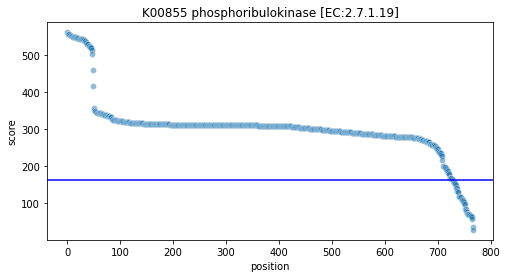

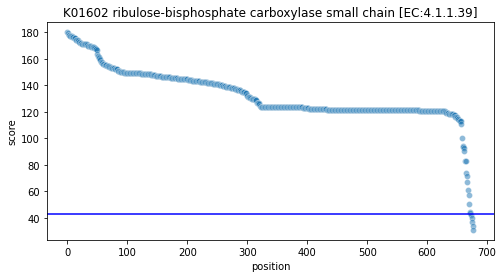

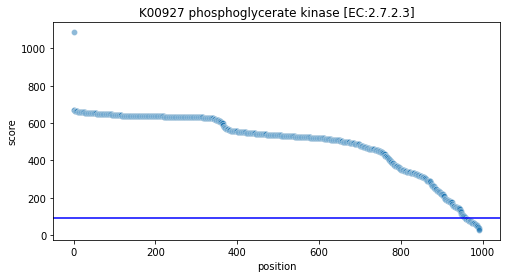

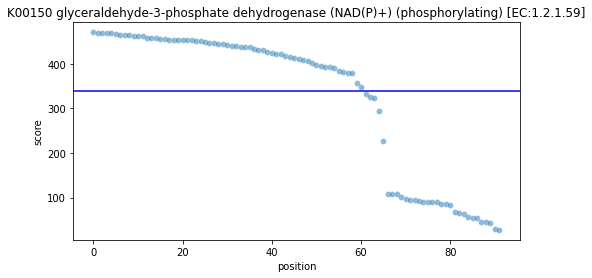

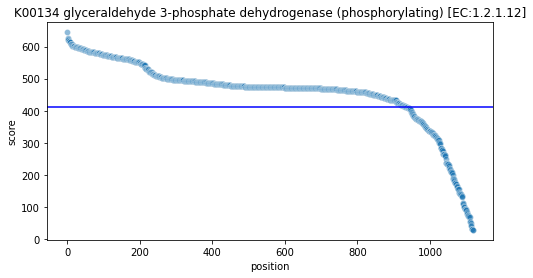

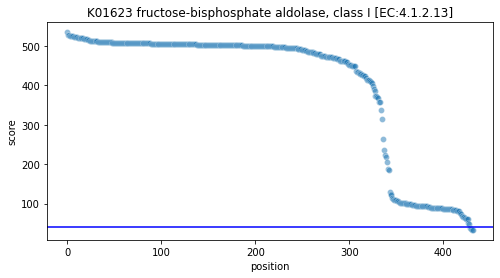

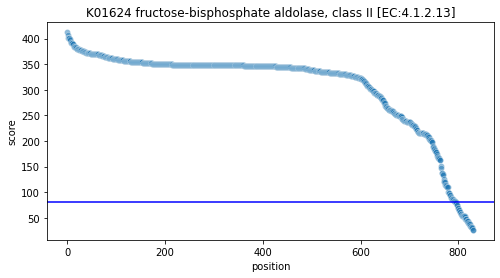

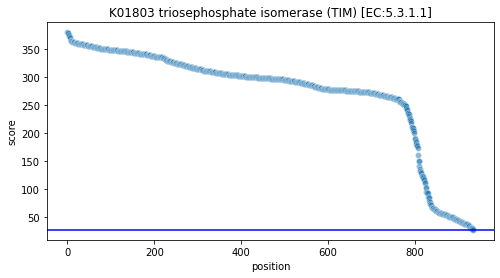

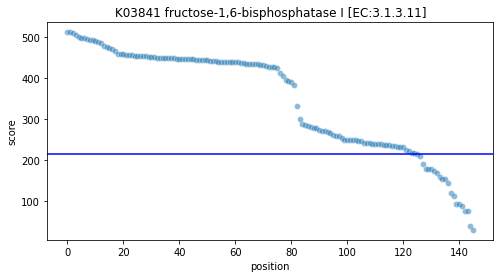

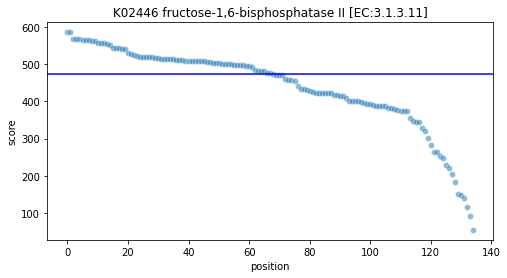

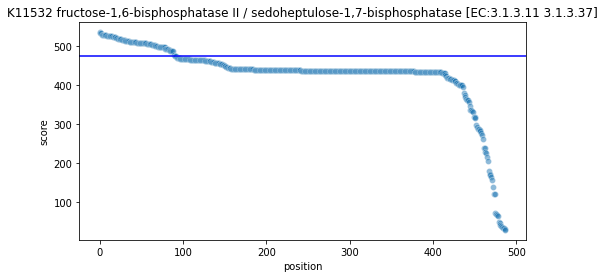

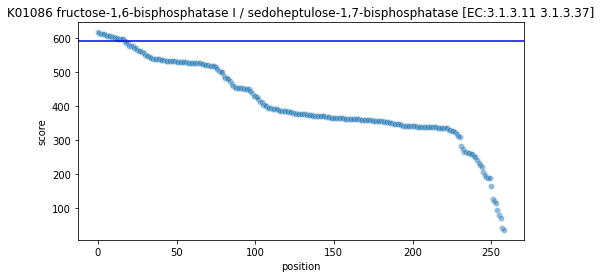

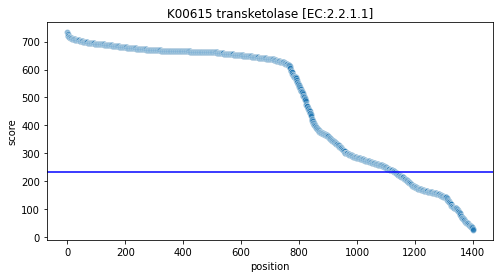

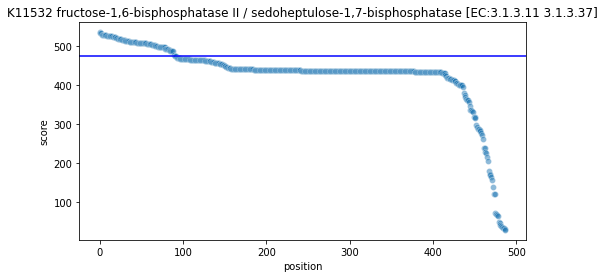

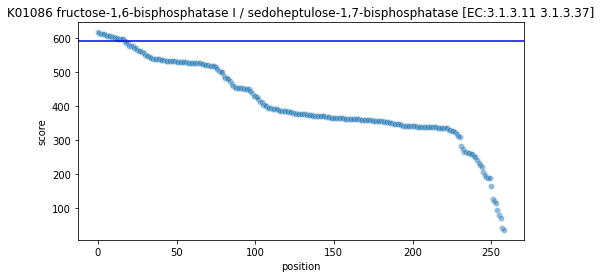

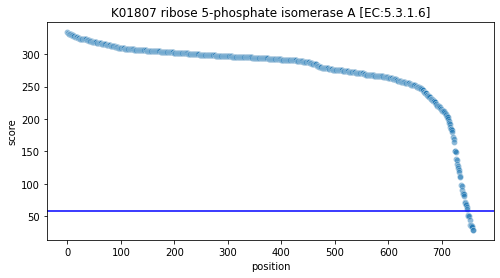

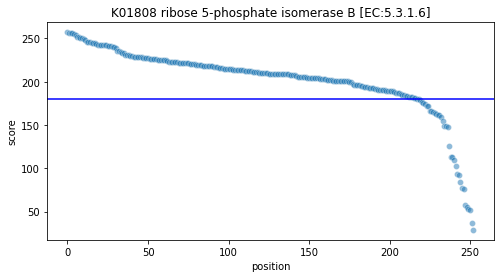

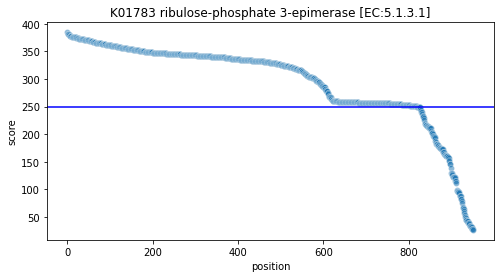

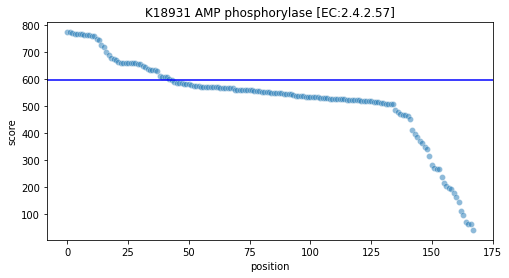

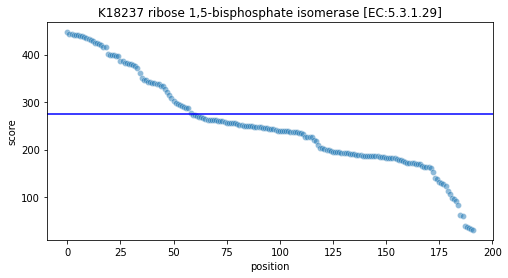

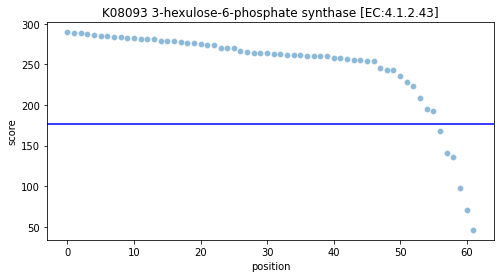

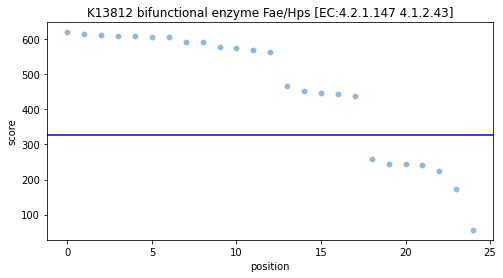

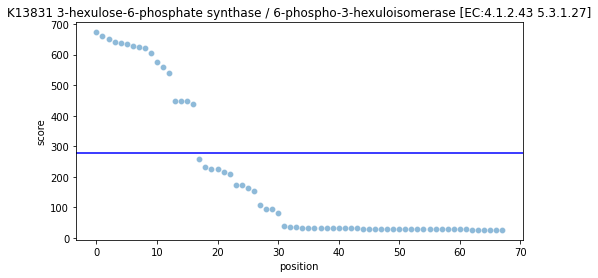

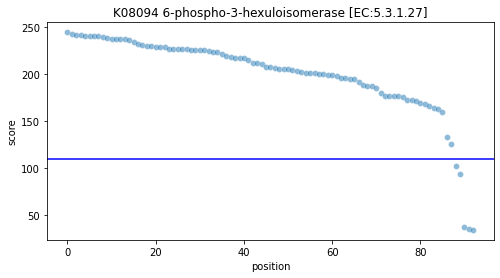

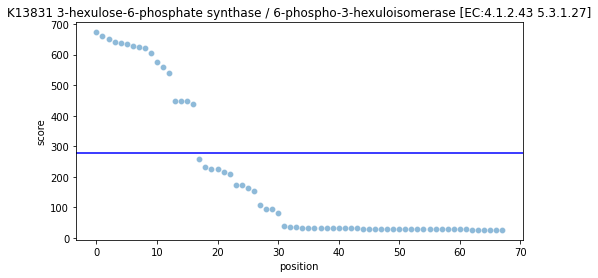

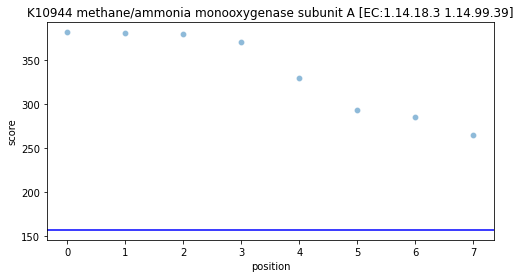

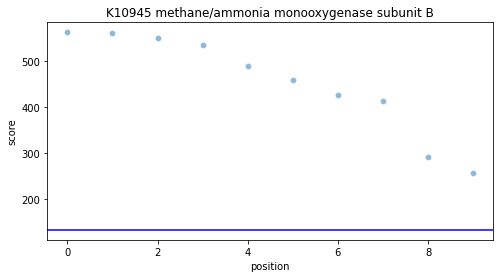

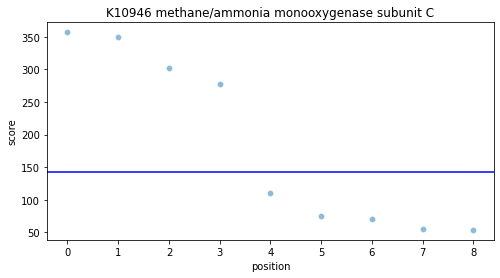

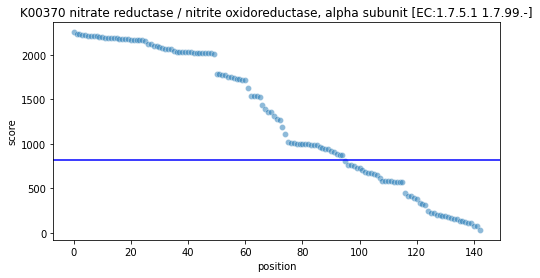

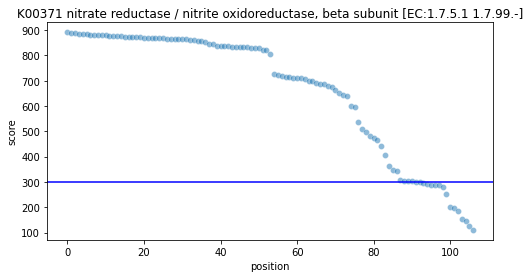

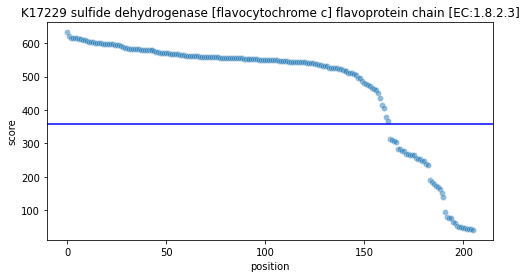

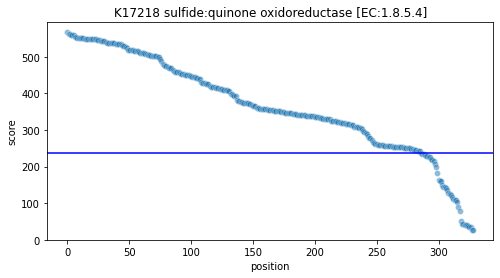

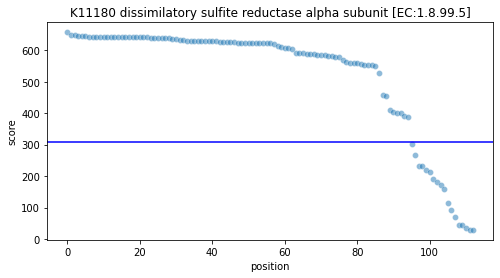

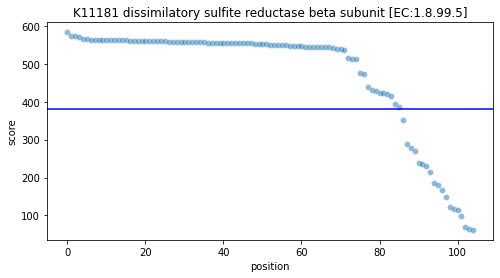

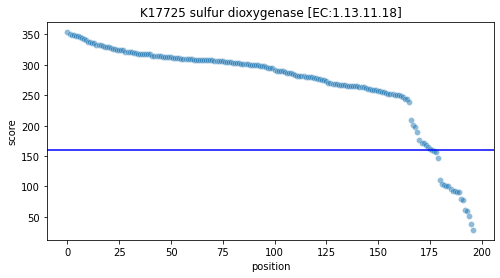

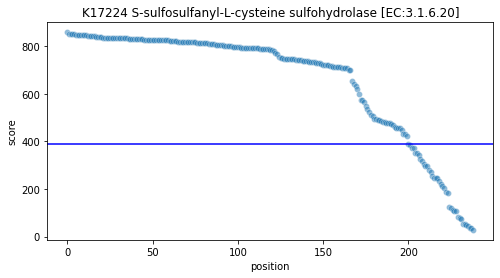

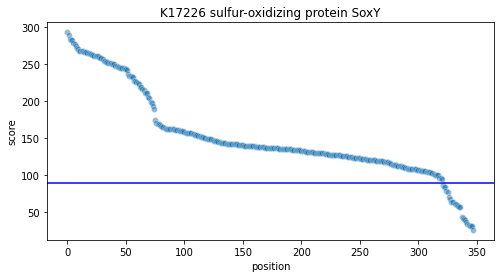

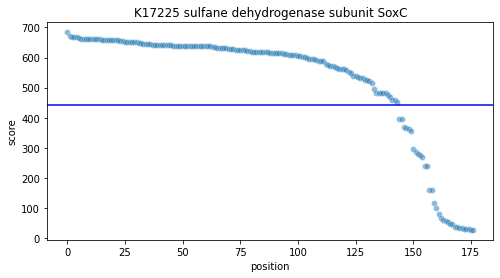

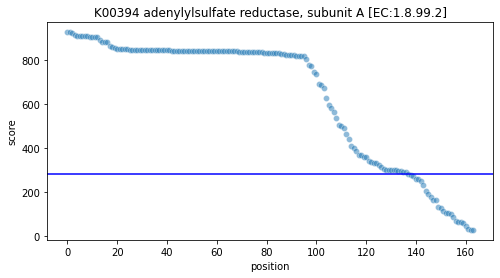

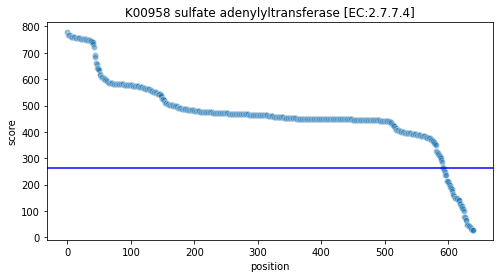

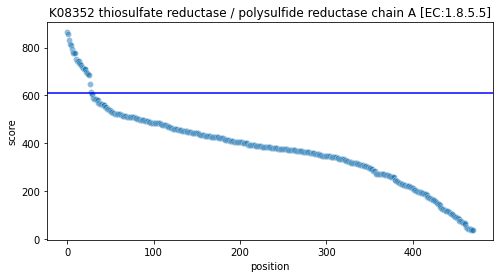

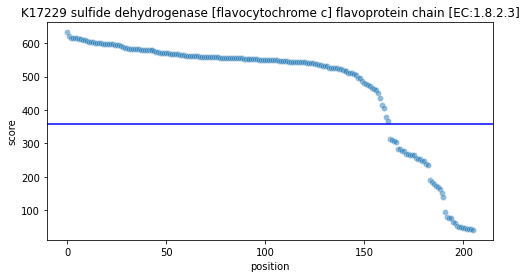

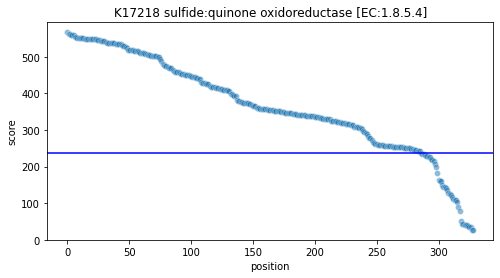

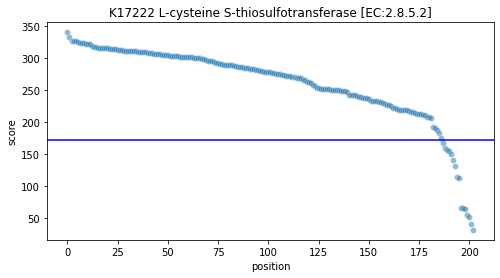

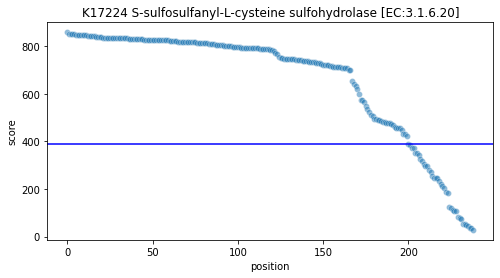

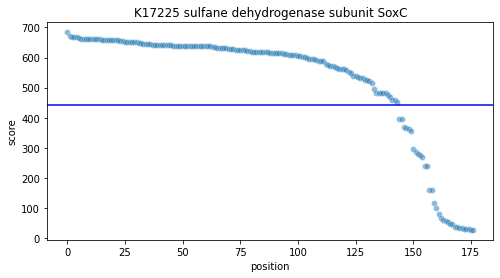

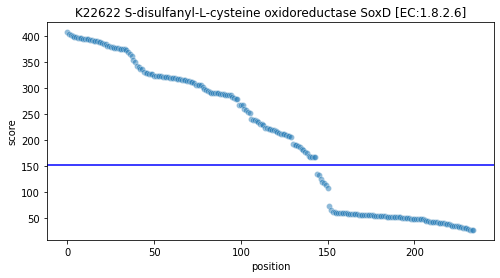

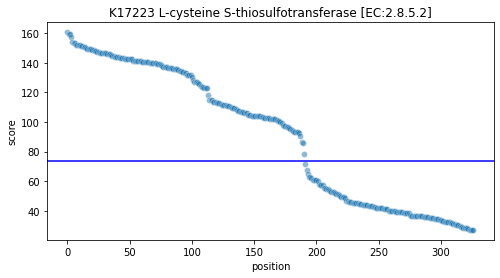

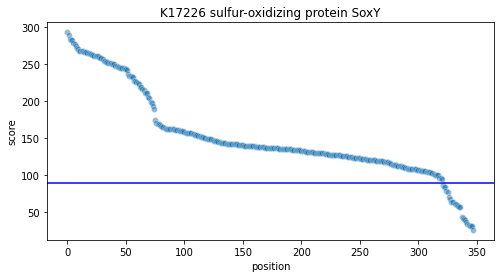

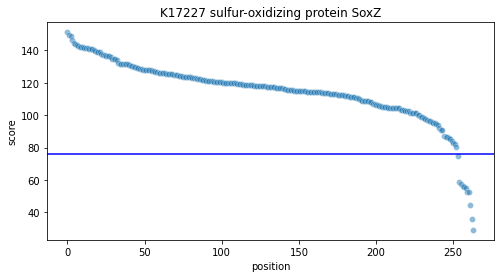

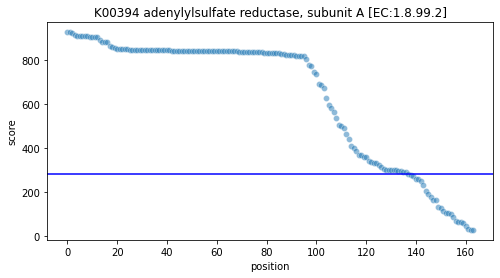

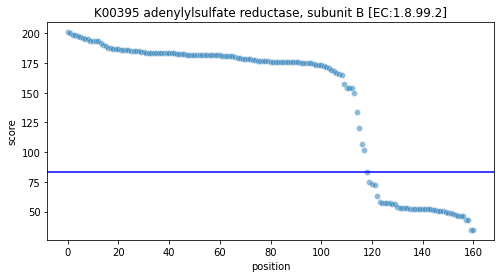

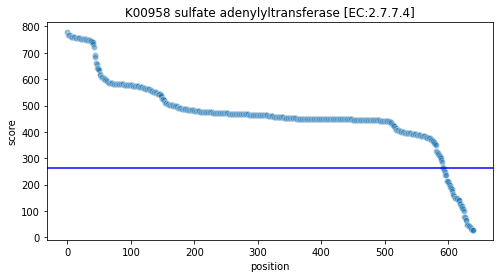

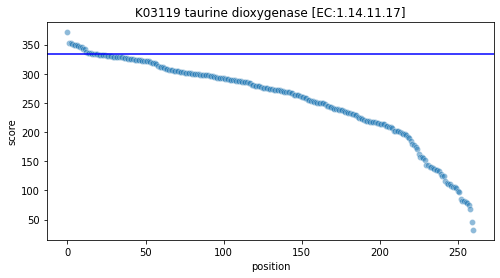

In [47]:
### export information for threshold setting
output_filtered = output[output["ko"].isin(kos_flat)]
tmp = {record[0]:record[1] for record in sfp(open(rootdir + "metabolism/nonredundant_genomes.faa"))}
viz_script = open(rootdir + "metabolism/thresholds/build.sh", "w")

for ko in kos_flat:
    
    subtable = output_filtered[output_filtered["ko"]==ko]
    
    if len(subtable) > 0:

        # plot it
        ko_hits_sub = subtable.sort_values("score", ascending=False).reset_index()
        ko_hits_sub["position"] = ko_hits_sub.index

        plt.figure(figsize=[8, 4])
        sns.scatterplot(x="position", y="score", data=ko_hits_sub, alpha=0.5)
        plt.axhline(float(ko_hits_sub["threshold"].iloc[0]), color="blue")
        plt.title(ko + " " + subtable["def"].iloc[0]) 
        plt.show()
        
        #output gene list
        ko_hits_sub["sequence"] = ko_hits_sub["gene"].map(tmp)
        ko_hits_sub[["gene", "score", "sequence"]].to_csv(rootdir + \
            "metabolism/thresholds/" + ko + ".csv", index=False)
        
        # make itol
        with open(rootdir + "metabolism/thresholds/" + ko + ".itol.txt", "w") as itol:
            itol.write("DATASET_SIMPLEBAR\nSEPARATOR COMMA\n")
            itol.write("DATASET_LABEL,%s\nCOLOR,#ff0000\nDATA\n" %(ko))
            for key, row in subtable.iterrows():
                itol.write("%s,%s\n" %(row["gene"], row["score"]))
        
        # build tree viz
        with open(rootdir + "metabolism/thresholds/" + ko + ".faa", "w") as faa:
            for key, row in ko_hits_sub.iterrows():
                faa.write(">%s\n%s\n" %(row["gene"].replace(",","_").replace(":","_"), row["sequence"]))
                
        viz_script.write("mafft --thread 20 --auto %s > %s\n" %(rootdir + "metabolism/thresholds/" + ko + ".faa", \
                                            rootdir + "metabolism/thresholds/" + ko + ".mafft"))
        viz_script.write("FastTreeMP %s > %s\n" %(rootdir + "metabolism/thresholds/" + ko + ".mafft", \
                                            rootdir + "metabolism/thresholds/" + ko + ".tre"))
    
viz_script.close()
tmp = {}

In [68]:
revised = {"K01623": 112.8, "K02446": 139.4, "K11532": 200,
                     "K01086": 200, "K01808": 100, "K01783": 125, "K18931": 275,
                     "K18237": 100, "K17218": 125, "K17226": 75, "K17225": 300,
                     "K00394": 335.9, "K00958": 200, "K08352": 515, "K17222": 125, "K03119": 125}

In [69]:
# apply thresholds
output_filtered["operational"] = output_filtered.apply(lambda x: revised[x["ko"]] if x["ko"] \
                                                                 in revised.keys() else float(x["threshold"]), axis=1)
output_final = output_filtered[output_filtered["score"]>=output_filtered["operational"]]
output_final.head(2)

,gene,ko,threshold,score,eval,def,bin,operational
2999,GORG_AG439B13_SAGS-scaffold_1_143,K00615,232.27,686.4,1.400000e-205,transketolase [EC:2.2.1.1],GORG_SAMEA6080221_SAGS_AG439B13,232.27
3109,MARD_MMP08886364_SAGS-scaffold_7_99,K00615,232.27,678.9,2.800000e-203,transketolase [EC:2.2.1.1],MARD_SAMN08886364_SAGS_MMP08886364,232.27


## probe the genomes

In [71]:
# set up the globals
gene_info = defaultdict(list)
pathway_info = defaultdict(list)
genomes = nr_genomes.query("scluster_rubisco_set!='IV'")["genome"].to_list()

### rubisco related - gene wise

In [72]:
for i,genome in enumerate(genomes):
       
    for key, row in kegg_md.iterrows():
        
        found = False
        orfs = []
        
        for ko in row["ko"].split(","):
            table = output_final[(output_final["ko"]==ko) & \
                                 (output_final["bin"]==genome)]
            if len(table) > 0:
                found=True
                orfs += table["gene"].to_list()
                
        gene_info["genome_name"].append(genome)
        gene_info["function"].append(row["pathway"])
        gene_info["gene"].append(row["gene"])
        gene_info["present"].append(found)
        orf_field = ",".join(orfs) if orfs != [] else "n/a"
        gene_info["hit_ids"].append(orf_field)
    
    print('processed %d of %d genomes\r'%((i+1), len(genomes)), end="")

### metabolic - gene and pathway wise

In [73]:
# modify a couple sulfur pathways
mod_funcs = {"#Function": ["65", "105", "106"], 
             "Entry": ["119||120||117||118", "130||131", "254"],
             "Category": ["Sulfur cycling"]*3,
             "Function": ["Sulfur oxidation", "Sulfite oxidation", "Sulfite production from org. sulfur"],
             "Gene abbreviation": ["sdo||sor||dsrAB", "aprA||sat", "tauD"]}

template = pd.read_csv("/home/groups/dekas/software/METABOLIC/METABOLIC_template_and_database/hmm_table_template_2.txt", sep="\t").fillna("None")
template_mod = pd.concat([template.query("Function!='Sulfur oxidation'"), pd.DataFrame.from_dict(mod_funcs)])
template_mod.tail()

,#Function,Entry,Category,Function,Gene abbreviation
102,103,195||196,Nitrile hydration,Nitrile hydratase,nthAB
103,104,209||210||211||212||213||214||215||216||217||2...,Metal reduction,Metal (Iron/Manganese) reduction,Iron reduction series genes
0,65,119||120||117||118,Sulfur cycling,Sulfur oxidation,sdo||sor||dsrAB
1,105,130||131,Sulfur cycling,Sulfite oxidation,aprA||sat
2,106,254,Sulfur cycling,Sulfite production from org. sulfur,tauD


In [74]:
for i, func in enumerate(funcs_of_interest + \
    ["Sulfite oxidation", "Sulfite production from org. sulfur"]):
    
    func_table = template_mod[template_mod["Function"]==func]
    
    if len(func_table) > 0:
        
        kos = []
        for key, row in func_table.iterrows():

            # get gene-kegg ids
            entries = [entry.lstrip("0") for entry in row["Entry"].split("||")]

            try:
                for item in entries:
                    for listing in hmm_dict[item]:
                        kos.append(listing)
            except KeyError:
                continue
        
        if len(kos) > 0:
        
            # now probe the genomes
            for genome in genomes:

                hit_count = 0
                hit_kos = []
                hit_ids = []

                for ko in kos:
                    
                    found = False
                    orfs = "n/a"
                    subtable = output_final[(output_final["bin"]==genome) &
                                    (output_final["ko"]==ko)]
                    
                    if len(subtable) > 0:
                        
                        hit_count +=1
                        hit_kos.append(ko)
                        hit_ids += subtable["gene"].to_list()
                        found = True
                        orfs = ",".join(subtable["gene"].to_list())
                        
                    # genes table
                    gene_info["genome_name"].append(genome)
                    gene_info["function"].append(func)
                    gene_info["gene"].append(ko)
                    gene_info["present"].append(found)
                    gene_info["hit_ids"].append(orfs)

                # pathway table
                pathway_info["function"].append(func)
                pathway_info["genome_name"].append(genome)
                pathway_info["hit_count"].append(hit_count)
                pathway_info["hit_total"].append(len(kos))
                pathway_info["hit_perc"].append(hit_count/len(kos)*100)
                pathway_info["hit_kos"].append(",".join(hit_kos))
                pathway_info["hit_ids"].append(",".join(hit_ids))

    print('processed %d of %d functions\r'%(i+1, len(funcs_of_interest) + 2), end="")

In [75]:
pathway_df = pd.DataFrame(pathway_info).query("hit_count>0")
pathway_df.tail(2)

,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids
8077,Sulfite production from org. sulfur,MARD_SAMN04026265_REFG_MMP04026265,1,1,100.0,K03119,MARD_MMP04026265_REFG-scaffold_458_4
8078,Sulfite production from org. sulfur,TARA_SAMEA4397215_METAG_NEFFHGEF,1,1,100.0,K03119,"TARA_SAMEA4397215_METAG-scaffold_2351_8,TARA_S..."


In [76]:
gene_df = pd.DataFrame(gene_info)
gene_df.head(2)

,genome_name,function,gene,present,hit_ids
0,OceanDNA-b21631,calvin_benson_bassham,prk,True,OceanDNA-b21631_00110_1
1,OceanDNA-b21631,calvin_benson_bassham,rubisco_small,False,n/a


## refine

In [77]:
to_remove = {}

### classify dsr - oxidative or reductive

In [102]:
cmdir(rootdir + "metabolism/dsr")

In [78]:
# references
f = "https://static-content.springer.com/esm/art%3A10.1038%2Fismej.2014.208/"\
    "MediaObjects/41396_2015_BFismej2014208_MOESM44_ESM.txt"

metadata = defaultdict(list)
with open(rootdir + "metabolism/dsr/muller_et_al_references.faa", "w") as out:
    for record in sfp(StringIO(requests.get(f).text)):
        
        metadata["seqid"].append(record[0].split("\t")[0])
        metadata["description"].append(record[0].split("\t")[1])
        metadata["accession"].append(record[0].split("\t")[2])
        metadata["category"].append(record[0].split("\t")[3])
        metadata["classification"].append(record[0].split("\t")[4])
        out.write(">%s\n%s\n" %(record[0], str(record[1]).replace("-","")))

metadf = pd.DataFrame(metadata)
metadf.head(2)

,seqid,description,accession,category,classification
0,PrbAero3,"Pyrobaculum aerophilum str. IM2, copy 1",NC_003364a,Thermophilic,Reductive archaeal type DsrAB;; Crenarchaeota;...
1,PrbAero4,"Pyrobaculum aerophilum str. IM2, copy 2",NC_003364b,Thermophilic,Reductive archaeal type DsrAB;; Crenarchaeota;...


In [79]:
# queries
tmp = {record[0]:record[1] for record in \
       sfp(open(rootdir + "metabolism/nonredundant_genomes.faa"))}
dsr_dict = {} # keep track of gene names

with open(rootdir + "metabolism/dsr/deepeco.faa", "w") as out:
    
    for genome in genomes:
        
        dsrA = gene_df[gene_df["genome_name"]==genome].query("gene=='K11180'")["hit_ids"].iloc[0].split(",")
        dsrB = gene_df[gene_df["genome_name"]==genome].query("gene=='K11181'")["hit_ids"].iloc[0].split(",")
        genome_all = dsrA + dsrB
        
        if len(genome_all) > 2: # deal with multicopy cases
            
            ctgs = [scaffold(gene) for gene in genome_all]
            mode = stats.mode(ctgs)
            dsrA = [item for item in dsrA if mode.mode[0] in item]
            dsrB = [item for item in dsrB if mode.mode[0] in item]

        if set(genome_all) != {"n/a"}:
            aseq = tmp[dsrA[0]] if dsrA[0] != 'n/a' else ''
            bseq = tmp[dsrB[0]] if dsrB[0] != 'n/a' else ''
            out.write(">%s\n%s\n" %(genome.split(".genes")[0], aseq+bseq))
            dsr_dict[genome.split(".genes")[0]] = dsrA + dsrB

/tmp/ipykernel_29271/2186561751.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(ctgs)
/home/users/ajaffe/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/tmp/ipykernel_29271/2186561751.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.h

In [80]:
# blast queries against ref
make = "makeblastdb -dbtype prot -in %s -out %s" %(rootdir + "metabolism/dsr/muller_et_al_references.faa", rootdir + "metabolism/dsr/muller_et_al_references.idx")
blast = "blastp -db %s -query %s -out %s -evalue 1e-3 -max_target_seqs 10 -num_threads 1 -sorthits 3 -outfmt 6" \
    %(rootdir + "metabolism/dsr/muller_et_al_references.idx", rootdir + "metabolism/dsr/deepeco.faa", rootdir + "metabolism/dsr/deepeco.blast")
print(make)
print(blast)

makeblastdb -dbtype prot -in /scratch/users/ajaffe/deepeco/metabolism/dsr/muller_et_al_references.faa -out /scratch/users/ajaffe/deepeco/metabolism/dsr/muller_et_al_references.idx
blastp -db /scratch/users/ajaffe/deepeco/metabolism/dsr/muller_et_al_references.idx -query /scratch/users/ajaffe/deepeco/metabolism/dsr/deepeco.faa -out /scratch/users/ajaffe/deepeco/metabolism/dsr/deepeco.blast -evalue 1e-3 -max_target_seqs 10 -num_threads 1 -sorthits 3 -outfmt 6


In [81]:
bresults = skbio.io.read(rootdir + "metabolism/dsr/deepeco.blast", format="blast+6", \
                         into=pd.DataFrame, default_columns=True)
# add in qcov info + quality filt
gene_lens = {record.description.split(" ")[0]:len(record.seq) for \
                record in SeqIO.parse(open(rootdir + "metabolism/dsr/deepeco.faa"), "fasta")}
bresults["qlen"] = bresults["qseqid"].map(gene_lens)
bresults["qcov"] = bresults.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
bfilt = bresults[(bresults["pident"]>=50) & (bresults["qcov"]>=0.70)]
bfilt = bfilt.sort_values("bitscore", ascending=False).drop_duplicates("qseqid")
bfilt.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov
438,OceanDNA-b42884,UncSUP05,98.509,805.0,0.0,1.0,1.0,793.0,1.0,805.0,0.0,1650.0,793,0.998739
166,OceanDNA-b43489,entry452,99.613,776.0,1.0,1.0,5.0,780.0,1.0,774.0,0.0,1615.0,781,0.992318
960,MARD_SAMN10285739_REFG_MMP10285739,MarPurpu,96.496,799.0,4.0,1.0,1.0,775.0,1.0,799.0,0.0,1603.0,775,0.998710
146,OC6_150m_MAG_303,entry452,97.423,776.0,18.0,1.0,5.0,780.0,1.0,774.0,0.0,1592.0,781,0.992318
212,OC6_3000m_MAG_285,entry452,97.036,776.0,21.0,1.0,5.0,780.0,1.0,774.0,0.0,1586.0,781,0.992318


In [82]:
dsr_merged = bfilt[["qseqid", "sseqid"]].merge(metadf, how="left", left_on="sseqid", right_on="seqid")
dsr_merged["classification"].value_counts()

classification
Oxidative bacterial type DsrAB;; Proteobacteria; Gammaproteobacteria; Gammaproteobacteria                 46
Oxidative bacterial type DsrAB;; Proteobacteria; Alphaproteobacteria; Alphaproteobacteria                 27
Oxidative bacterial type DsrAB;; Proteobacteria; Deltaproteobacteria; SAR324 lineage                       4
Oxidative bacterial type DsrAB;; Proteobacteria; Betaproteobacteria; Betaproteobacteria                    2
Reductive bacterial type DsrAB; Environmental supercluster 1; Unclassified; Unclassified; Unclassified     1
Name: count, dtype: int64

In [83]:
for key, row in dsr_merged[~dsr_merged["classification"].str.contains("Oxidative")].iterrows():
    tmpp = {"Sulfur oxidation": {"kos":["K11180", "K11181"], "ids": dsr_dict[row["qseqid"]]}}
    to_remove[row["qseqid"]] = tmpp

### prune sdo 

In [85]:
cmdir(rootdir + "metabolism/sdo")

In [86]:
with open(rootdir + "metabolism/sdo/deepeco.faa", "w") as out:
    
    for genome in genomes:
        
        sdos = gene_df[gene_df["genome_name"]==genome].query("gene=='K17725'")["hit_ids"].iloc[0].split(",")
        for sdo in sdos:
            if sdo != "n/a":
                out.write(">%s\n%s\n" %(sdo, tmp[sdo]))

In [87]:
# add seqs to reference alignment from Zhou personal communication
cmd = "mafft --add %s --keeplength %s > %s" \
    %(rootdir + "metabolism/sdo/deepeco.faa", rootdir + "metabolism/sdo/Sdo_proteins_and_ref.faa.mafft.1line.fasta",
      rootdir + "metabolism/sdo/merged_sdo.mafft")
print(cmd)

mafft --add /scratch/users/ajaffe/deepeco/metabolism/sdo/deepeco.faa --keeplength /scratch/users/ajaffe/deepeco/metabolism/sdo/Sdo_proteins_and_ref.faa.mafft.1line.fasta > /scratch/users/ajaffe/deepeco/metabolism/sdo/merged_sdo.mafft


In [88]:
sdo_info = defaultdict(list)

for record in sfp(open(rootdir + "metabolism/sdo/merged_sdo.mafft")):
    
    sdo_info["sequence"].append(record[0])
    sdo_info["deepeco"].append(record[0] in [record[0] for record in \
        sfp(open(rootdir + "metabolism/sdo/deepeco.faa"))])
    sdo_info["residue_1"].append(record[1][736])
    sdo_info["residue_2"].append(record[1][852])
    sdo_info["fullseq"].append(record[1].replace("-", ""))

sdo_df = pd.DataFrame(sdo_info)
sdo_df.head()

,sequence,deepeco,residue_1,residue_2,fullseq
0,128-326_maxbin2_scaf2bin.035~~128-326_scaffold...,False,G,-,MFIKTLAVGPLETNCYLIGCEETGEGAVIDPGGDAPVILAAVEEAG...
1,128-326_maxbin2_scaf2bin.045~~128-326_scaffold...,False,N,-,MHRDEQTPYTIEALELGPMENFVYLVSDRASGRAAVVDPAWEVDRI...
2,128-326_maxbin2_scaf2bin.054~~128-326_scaffold...,False,G,-,MILEQLVVGPIQANCYILGDETTREAVVIDPGGDTPMILRALQARD...
3,128-326_maxbin2_scaf2bin.089~~128-326_scaffold...,False,G,-,MGLDVREVTVGPLEVNCYVLHDTGSGEAIVVDPGDEPERILDLLKP...
4,128-326_maxbin2_scaf2bin.117~~128-326_scaffold...,False,N,-,MTTKTHAIHALELGPMDNFVYLIQDLESNRGAIVDPAWDVQQVIKL...


In [91]:
otbd = {row[0]:row[1] for key, row in pd.read_csv(rootdir + \
        "metabolism/nonredundant_genomes.otb", sep="\t", header=None).iterrows()}

for key, row in sdo_df.query("deepeco==True").iterrows():
    
    if (row["residue_1"]!='D') or (row["residue_2"]!='N'):
        
        genome = otbd[row["sequence"]]
        if genome not in to_remove.keys():
            tmpp = {"Sulfur oxidation": {"kos":["K17725"], "ids": [row["sequence"]]}}
            to_remove[genome] = tmpp
        else:
            to_remove[genome]["Sulfur oxidation"]["kos"].append("K17725")
            to_remove[genome]["Sulfur oxidation"]["ids"].append(row["sequence"])

### distinguish nxr/nar + amo/pmo

In [126]:
cmdir(rootdir + "metabolism/trees")

In [92]:
families = {"dmso": ["Nitrite oxidation"], "cummo": ["Ammonia oxidation",
            "Methane oxidation - Partculate methane monooxygenase"]}

for family in families.keys():
    
    with open(rootdir + "metabolism/trees/" + family + "_merged.faa", "w") as out:
    
        # write out deepeco seqs
        gene_subset = gene_df[gene_df["function"].isin(families[family])].query("present==True")  
        
        for key, row in gene_subset.drop_duplicates("hit_ids").iterrows():
            if row["gene"] in ["K10944", "K00370"]:
                for orf in row["hit_ids"].split(","):
                    out.write(">%s\n%s\n" %(orf, tmp[orf]))
                    
        # write out references
        ref = rootdir + "metabolism/trees/" + \
              ("boddicker_mosier.fasta" if family=="dmso" else "diamond_et_al.faa")
        for record in sfp(open(ref)):
            out.write(">%s\n%s\n" %(record[0], record[1]))

Then manually align, tree build...

In [93]:
nxrs = ["MARD_MMP02436141_REFG-scaffold_1_3192", "MARD_MMP02436141_REFG-scaffold_1_126",
    "MARD_MMP02436084_REFG-scaffold_4_57", "MARD_MMP02436084_REFG-scaffold_6_6"]

amos = ["MARD_MMP02436179_REFG-scaffold_12_1842", "MARD_MMP08707727_REFG-scaffold_33_1",
    "TARA_SAMEA4397174_METAG-scaffold_17085_6", "TARA_SAMEA2622737_METAG-scaffold_18_1"]

# then trim out others, including other subunits
for key, row in pathway_df[pathway_df["function"].isin(["Ammonia oxidation", "Nitrite oxidation"])].iterrows():
    
    any_found = True in [orf in nxrs+amos for orf in row["hit_ids"].split(",")]
    
    if (any_found == False) or ("Methane" in row["function"]):
        
        if row["genome_name"] not in to_remove.keys():
            to_remove[row["genome_name"]] = {row["function"]: {"kos":row["hit_kos"].split(","), "ids": row["hit_ids"].split(",")}}
        else:
            to_remove[row["genome_name"]][row["function"]] = {"kos": row["hit_kos"].split(","), "ids": row["hit_ids"].split(",")}
            
# remove all methane as none found
gene_df = gene_df.query("function!='Methane oxidation - Partculate methane monooxygenase'")
pathway_df = pathway_df.query("function!='Methane oxidation - Partculate methane monooxygenase'")

N.B. a few xmo's that could'nt be classified - from various proteos as well as two from SAR324 - possibly for alkanes, or other substrates... (see literature)

### hydrogenases

In [94]:
cmdir(rootdir + "metabolism/hyd")

Use supp materials from Lappan ... Greening et al. 2023 (new data and ref db).

In [100]:
with open(rootdir + "metabolism/hyd/hyd_refs.faa", "w") as out:
    
    for key, row in pd.read_csv(rootdir + "metabolism/hyd/lappan_et_al.csv").iterrows():
        if row["Gene name"] == "NiFe":
            orf_name = row["Query title (MAG gene)"].split(" ")[0]
            nife_type = row["Subject title (closest database match)"].split("-")[-1]
            nife_type_mod = "_".join(["NiFe"] + nife_type.split(" ")[2:])
            out.write(">%s\n%s\n" %("_".join([orf_name,nife_type_mod]), row["MAG protein sequence"]))
    
    for record in sfp(open(rootdir + "metabolism/hyd/greening_lab_nife.fasta")):
        cleaned_name = record[0].replace("[", "").replace("]", "").replace(" - ", "_").replace(" ", "_")
        out.write(">%s\n%s\n" %(cleaned_name, record[1]))
            
# set up diamond run
make = "diamond makedb --db %s --in %s --threads 1" %(rootdir + "metabolism/hyd/hyd_refs.dmnd", \
                                                       rootdir + "metabolism/hyd/hyd_refs.faa")
call = "diamond blastp -d %s -q %s -o %s --threads 5 -b8 -c1" %(rootdir + "metabolism/hyd/hyd_refs.dmnd", \
                                                                 rootdir + "metabolism/nonredundant_genomes.faa", \
                                                                 rootdir + "metabolism/hyd/hyd.results")
print(call)

diamond blastp -d /scratch/users/ajaffe/deepeco/metabolism/hyd/hyd_refs.dmnd -q /scratch/users/ajaffe/deepeco/metabolism/nonredundant_genomes.faa -o /scratch/users/ajaffe/deepeco/metabolism/hyd/hyd.results --threads 5 -b8 -c1


In [103]:
hresults = skbio.io.read(rootdir + "metabolism/hyd/hyd.results", format="blast+6", \
                         into=pd.DataFrame, default_columns=True)
gene_lens = {record[0]:len(record[1]) for \
                record in sfp(open(rootdir + "metabolism/nonredundant_genomes.faa"))}
hresults["qlen"] = hresults["qseqid"].map(gene_lens)
hresults["qcov"] = hresults.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
hfilt = hresults[(hresults["pident"]>=50) & (hresults["qcov"]>=0.80)].sort_values("bitscore", ascending=False).drop_duplicates("qseqid")
hfilt["bin"] = hfilt["qseqid"].map(otbd)
hfilt["putative_hyd_type"] = hfilt["sseqid"].apply(lambda x: x.split("_")[-1])
# for now, filter to just aerobic uptake hydrogenases (see lappan et al.)
hfilt = hfilt[hfilt["putative_hyd_type"].isin(["1d", "1l", "2a"])]
hfilt["putative_hyd_type"].value_counts()

putative_hyd_type
1d    48
2a    40
Name: count, dtype: int64

In [104]:
## check with quick tree - only one seems off
hfilt = hfilt[hfilt["qseqid"]!="OceanDNA-b33308_01347_1"]
hfilt["putative_hyd_type"].value_counts()

putative_hyd_type
1d    47
2a    40
Name: count, dtype: int64

In [105]:
# store the information
hyd_pathway = defaultdict(list)
hyd_gene = defaultdict(list)

for genome in pathway_df["genome_name"].unique():
    
    subtable = hfilt[hfilt["bin"]==genome]
    
    if len(subtable) > 0:
        
        hit_ids = ",".join(subtable["qseqid"].unique())
        hyd_pathway["function"].append("Aerobic Hydrogen Oxidation")
        hyd_pathway["genome_name"].append(genome)
        hyd_pathway["hit_count"].append(1)
        hyd_pathway["hit_total"].append(1)
        hyd_pathway["hit_perc"].append(100.0)
        hyd_pathway["hit_kos"].append("NiFe hydrogenase (1d, 1l, 2a)")
        hyd_pathway["hit_ids"].append(hit_ids)

pathway_df = pd.concat([pathway_df, pd.DataFrame(hyd_pathway)])

for genome in gene_df["genome_name"].unique():
    
    subtable = hfilt[hfilt["bin"]==genome]
    
    if len(subtable) > 0:
        hit_ids = ",".join(subtable["qseqid"].unique())
    else: hit_ids = "n/a"
        
    hit_ids = ",".join(subtable["qseqid"].unique())
    hyd_gene["genome_name"].append(genome)
    hyd_gene["function"].append("Aerobic Hydrogen Oxidation")
    hyd_gene["gene"].append("NiFe hydrogenase (1d, 1l, 2a)")
    hyd_gene["present"].append(len(subtable)>0)
    hyd_gene["hit_ids"].append(hit_ids)

gene_df = pd.concat([gene_df, pd.DataFrame(hyd_gene)])

In [106]:
gene_lens={}
otbd = {}
tmp = {}

### trim both dataframes

In [107]:
mod_pathway_info = defaultdict(list)

for key, row in pathway_df.iterrows():
    
    retain = False
    if row["genome_name"] in to_remove.keys():
        
        if row["function"] in to_remove[row["genome_name"]].keys():
            
            kos_remove = to_remove[row["genome_name"]][row["function"]]["kos"]
            orfs_remove = to_remove[row["genome_name"]][row["function"]]["ids"]
            #new_hit_kos = [ko for ko in row["hit_kos"].split(",") if ko not in kos_remove]
            new_hit_ids = [orf for orf in row["hit_ids"].split(",") if orf not in orfs_remove]
            new_hit_kos = [output_final[output_final["gene"]==orf]["ko"].iloc[0] for orf in new_hit_ids]
            
            if len(new_hit_kos) > 0:
                
                for col in ["function", "genome_name", "hit_total"]:
                    mod_pathway_info[col].append(row[col])
                mod_pathway_info["hit_count"].append(len(new_hit_kos))
                mod_pathway_info["hit_perc"].append((len(new_hit_kos)/row["hit_total"])*100)
                mod_pathway_info["hit_kos"].append(",".join(new_hit_kos))
                mod_pathway_info["hit_ids"].append(",".join(new_hit_ids))
        
        else: retain=True
            
    else: retain =True
    
    if retain == True:
        for column in pathway_df.columns:
            mod_pathway_info[column].append(row[column])

mod_pathway_df = pd.DataFrame(mod_pathway_info)

In [108]:
mod_gene_info = defaultdict(list)

to_remove_flat = []
for item in to_remove.values():
    for key in item.keys():
        to_remove_flat+=item[key]["ids"]

for key, row in gene_df.iterrows():
        
    tr = []
    for orf in row["hit_ids"].split(","):
        if orf in to_remove_flat:
            tr.append(orf)
    
    if (tr != ["n/a"]) and (tr!=[]):
        
        for col in ["genome_name", "function", "gene"]:
            mod_gene_info[col].append(row[col])
        new_hit_ids = [orf for orf in row["hit_ids"].split(",") if orf not in tr]
        mod_gene_info["present"].append(True if len(new_hit_ids)>0 else False)
        mod_gene_info["hit_ids"].append("_".join(new_hit_ids) if len(new_hit_ids)>0 else "n/a")
    else:
        for column in gene_df.columns:
            mod_gene_info[column].append(row[column])
            
mod_gene_df = pd.DataFrame(mod_gene_info)

### control for pathway completeness

In [109]:
counts = {"Sulfite oxidation": 2}

In [110]:
mod_pathway_df["count_threshold"] = mod_pathway_df["function"].apply(lambda x: counts[x] if x in counts else 1)
mod_pathway_df = mod_pathway_df[mod_pathway_df["hit_count"]>=mod_pathway_df["count_threshold"]]

## export

In [111]:
mod_pathway_df.query("function!='Sulfate reduction'").sort_values(["function", \
                     "genome_name"]).to_csv(rootdir + "tables/metabolic_pathway_info.tsv", sep="\t", index=False)
mod_gene_df.query("function!='Sulfate reduction'").sort_values(["genome_name", \
                     "function", "gene"]).to_csv(rootdir + "tables/metabolic_gene_info.tsv", sep="\t", index=False)

cmd = 'rclone copy tables/ drive:deepeco/tables --include "metabolic_*_info.tsv" --progress'
print(cmd)

rclone copy tables/ drive:deepeco/tables --include "metabolic_*_info.tsv" --progress


In [174]:
## supp table - N.B. needs manual filling some cases after export
base = mod_gene_df.drop_duplicates("gene").drop(["present", "hit_ids", "genome_name"], axis=1)
base = base.merge(kegg_md[["gene", "ko"]], how="left").rename(columns={"ko":"cc_ko"}).fillna("None")
base = base.merge(catalogue[["Corresponding KO", "Gene abbreviation"]], \
           how="left", left_on="gene", right_on="Corresponding KO").drop_duplicates().rename(columns={"Gene abbreviation":"cat_gene"})
base["category"] = base["function"].apply(lambda x: "rubisco_related" if "_" in x else "paired_catabolism")
base["gene_abbreviation"] = base.apply(lambda x: x["gene"] if "_" in x["function"] else x["cat_gene"], axis=1)
base["corresponding_ko"] = base.apply(lambda x: x["cc_ko"] if "_" in x["function"] else x["Corresponding KO"], axis=1)
base = base.dropna(axis=0, subset="corresponding_ko")
base["ko_single"] = base["corresponding_ko"].apply(lambda x: x.split(",")[-1])
base = base.merge(output_final[["ko", "def", "operational"]], how="left", left_on="ko_single", right_on="ko")
base = base[["category", "function", "gene_abbreviation", "def", "corresponding_ko", \
      "operational"]].drop_duplicates().sort_values(["category", "function", "gene_abbreviation"], ascending=[False,True,True])
base.to_csv(rootdir + "tables/table_s4.tsv", sep="\t", index=False)

In [243]:
gsupp = mod_gene_df[mod_gene_df["gene"].isin(kegg_md["gene"].unique())]
gpiv = gsupp.pivot(index="genome_name", columns="gene", values="hit_ids").reset_index().replace("n/a", "None")
gpiv = gpiv.merge(nr_genomes[["genome", "classification", "scluster_rubisco_set"]], how="left", left_on="genome_name", right_on="genome")
gpiv["lineage"] = gpiv["classification"].apply(lambda x: ";".join(x.split(";")[0:3]))
gpiv["order"] = gpiv["classification"].apply(lambda x: x.split(";")[3])
gpiv[["genome_name", "lineage", "order", "scluster_rubisco_set"] +
     [c for c in gpiv.columns if c not in ["genome_name", "lineage", \
     "order", "scluster_rubisco_set"]]].drop(["genome","classification"], axis=1).to_csv(rootdir + "tables/table_s5.tsv", sep="\t", index=False)

In [247]:
psupp = mod_pathway_df.merge(gpiv[["genome_name", "lineage", "order", "scluster_rubisco_set"]], how="left")
psupp[["genome_name", "lineage", "order", "scluster_rubisco_set", \
       "function", "hit_kos", "hit_ids"]].to_csv(rootdir + "tables/table_s6.tsv", sep="\t", index=False)